# 13-Sequence Data

[1.Copurs(Text Dataset)](#1)

[2.Tokenize](#2)
 - [2-1.Special Tokens](#2-1)
 - [2-2.Define Tokenizer](#2-2)
 - [2-3.Tokenize Dataset](#2-3)

[3.Embedding & t-SNE](#3)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, FastText

<a id="1"></a>
## 1.Corpus(Text Dataset)

In [2]:
train_iter = Multi30k(split='train', language_pair=("de", "en"))

for data in train_iter:
    print(data)

    break

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


<a id="2"></a>
## 2.Tokenize

<a id="2-1"></a>
### 2-1.Special Tokens

In [3]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

<a id="2-2"></a>
### 2-2.Define Tokenizer

In [4]:
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

<a id="2-3"></a>
### 2-3.Tokenize Dataset

In [5]:
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [6]:
print(vocab_transform)

{'de': Vocab(), 'en': Vocab()}


In [7]:
sample = "I like apple."

token_transform[TGT_LANGUAGE](sample)

['I', 'like', 'apple', '.']

<a id="3"></a>
## 3.Embedding & t-SNE

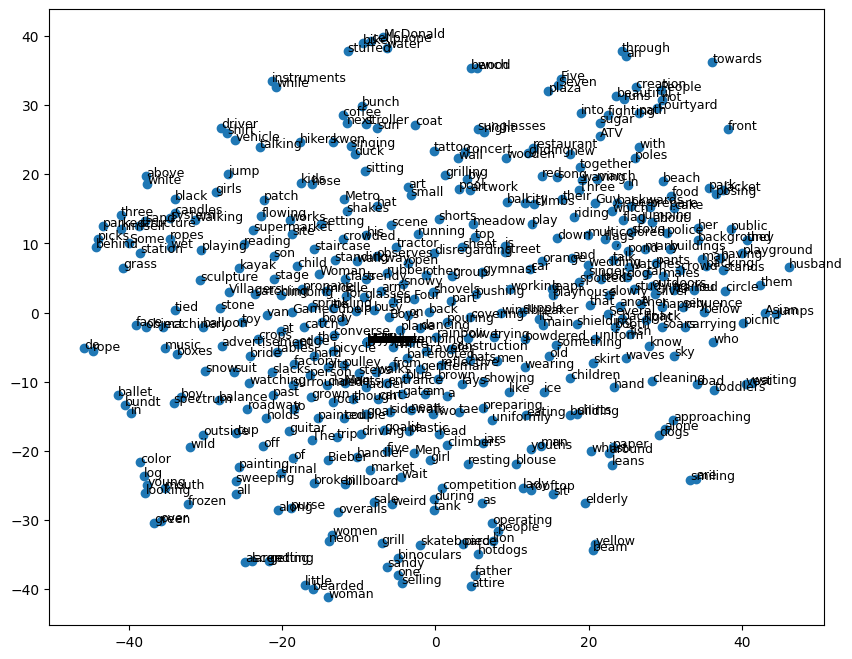

In [11]:
def get_embeddings_from_dataset(train_data, token_transform, glove_vectors, num_samples=10):
    unique_tokens_set = set()  # 중복을 제거하기 위한 세트 생성
    embeddings_list = []
    tokens_list = []
    for idx, (_, en) in enumerate(train_data):
        if idx >= num_samples:
            break

        # 문장을 토큰화.
        tokens = token_transform[TGT_LANGUAGE](en)
        unique_tokens = set(tokens)  # 현재 문장의 고유 토큰
        new_tokens = unique_tokens - unique_tokens_set  # 이전에 처리되지 않은 고유 토큰
        unique_tokens_set.update(new_tokens)  # 처리된 토큰 업데이트

        for token in new_tokens:
            if token in glove_vectors.stoi:
                # 단일 토큰에 대해 임베딩을 조회하고 numpy 배열로 변환
                embedding = glove_vectors.get_vecs_by_tokens(token, lower_case_backup=True).numpy()
            else:
                # GloVe 임베딩에 토큰이 없는 경우, <unk>의 임베딩을 사용
                embedding = glove_vectors.get_vecs_by_tokens("<unk>", lower_case_backup=True).numpy()
            embeddings_list.append(embedding)
            tokens_list.append(token)

    return np.vstack(embeddings_list), list(unique_tokens_set)

embedder = GloVe(name='6B', dim=300)
# embedder = FastText()
train_data = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

embeddings, tokens = get_embeddings_from_dataset(train_data, token_transform, embedder, num_samples=100)
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, token in enumerate(tokens):
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
plt.show()
